**Facial Recognition System For Autistic children using a Swin Transformer**

**Problem Statement**

Problem Statement
The goal is to develop a facial recognition model that can accurately identify and classify images of children's faces as either autistic or non-autistic based on facial features.

**Dataset**

The Autistic Children Facial Dataset is a specialized collection of images intended for research and development in the field of autism detection through facial recognition technology. This dataset comprises photographs and images specifically focusing on the facial features of children diagnosed with autism spectrum disorder (ASD). The dataset is curated to include images of both autistic and neurotypical (non-autistic) children, providing a comparative basis for analysis .

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autistic-children-facial-data-set/autism-S-224-89.33.h5
/kaggle/input/autistic-children-facial-data-set/autism-2.txt
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0664.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/1269.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0733.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0106.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0375.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/1075.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0285.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0591.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0799.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/1411.jpg
/kaggle/input/autistic-children-facial-data-set/consolidated/autistic/0074.jpg


**Import libraries** 

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

**installs and imports the timm library and its LabelSmoothingCrossEntropy**

In [3]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

**remove warnings**

In [4]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

**Access system-specific parameters and functions, manipulate the runtime environment.**

In [6]:
import sys
from tqdm import tqdm
import time
import copy

**retrieves the class names from a dataset stored in a directory**

In [7]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

**preparing data for training and evaluation in a PyTorch deep learning pipeline**

In [8]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

**Define the Dataset Path**

In [9]:
dataset_path = "/kaggle/input/autistic-children-facial-data-set/"

**data loaders for your dataset**

In [10]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 64, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 16, train=False)

**Define the Function to Get Class Names**

In [11]:
classes = get_classes("/kaggle/input/autistic-children-facial-data-set/train/")
print(classes, len(classes))

['autistic', 'non_autistic'] 2


**Show dataset simples**

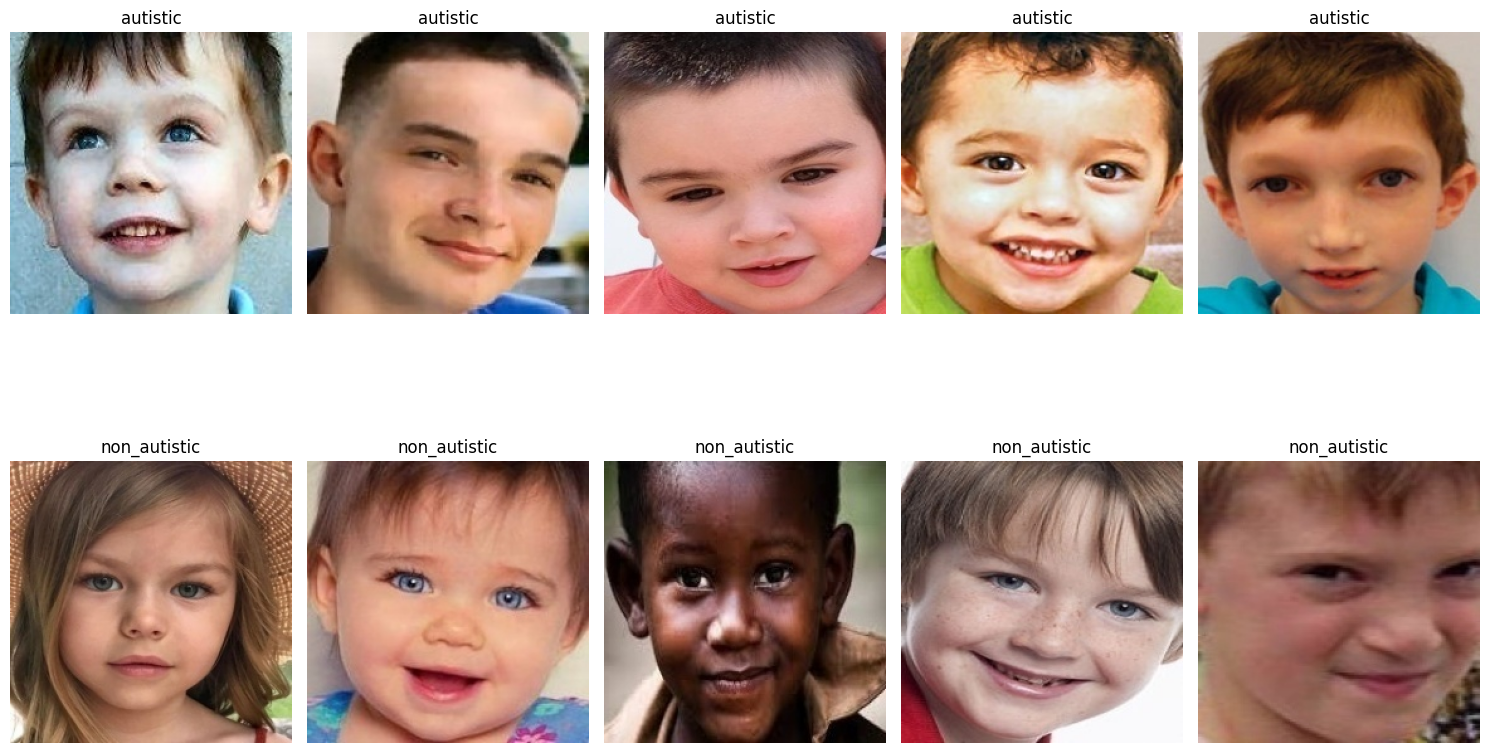

In [12]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define the path to the training dataset
train_data_path = "/kaggle/input/autistic-children-facial-data-set/train/"

# Get the list of classes (subdirectories) in the training dataset
classes = os.listdir(train_data_path)

# Load a few sample images from each class
num_samples_per_class = 5  # Number of samples to display per class

plt.figure(figsize=(15, 10))

# Loop through each class and display sample images
for i, class_name in enumerate(classes):
    class_path = os.path.join(train_data_path, class_name)
    class_images = os.listdir(class_path)[:num_samples_per_class]
    
    for j, image_name in enumerate(class_images):
        image_path = os.path.join(class_path, image_name)
        image = plt.imread(image_path)
        
        plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


**organizes the data loaders and dataset sizes into dictionaries**

In [13]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

**prints the lengths of the training, validation, and test data loaders**

In [14]:
print(len(train_loader), len(val_loader), len(test_loader))

40 7 19


**prints the lengths of the training, validation, and test datasets**

In [15]:
print(train_data_len, valid_data_len, test_data_len)

2536 100 300


**set up the computing device for training a model using PyTorch**

In [16]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**to load a pre-trained Swin Transformer model**

The swin_tiny_patch4_window7_224 model which is designed for tasks such as image classification.

In [17]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Downloading: "https://github.com/SharanSMenon/swin-transformer-hub/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth
100%|██████████| 109M/109M [00:00<00:00, 258MB/s]  


**modifies a pre-trained model to customize**

In [18]:
# Freeze pretrained model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the head for binary classification
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 1),  # Output size 1 for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary classification
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=1, bias=True)
  (4): Sigmoid()
)


**Defining the Loss Function and Optimizer**

In [19]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

**Learning Rate Scheduler**

In [20]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.97)

## **Training Method** 

This method will handle the training loop, updating the model weights

In [21]:
import time
import copy
from tqdm import tqdm
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)
        
        for phase in ['train', 'val']:  # Training and validation phase per epoch
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)  # Ensure labels are of shape (batch_size, 1)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):  # No autograd for validation
                    outputs = model(inputs)
                    preds = torch.round(outputs)  # Threshold 0.5 for binary classification
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()  # Step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # Keep the best validation accuracy model
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"Best Val Acc: {best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)
    return model


**model training**

In [22]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40) # now it is a lot faster
# I will come back after 10 epochs

Epoch 0/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


train Loss: 0.5397 Acc: 0.7157


100%|██████████| 7/7 [00:00<00:00, 11.68it/s]


val Loss: 0.4774 Acc: 0.7700

Epoch 1/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


train Loss: 0.4706 Acc: 0.7689


100%|██████████| 7/7 [00:00<00:00, 12.65it/s]


val Loss: 0.4690 Acc: 0.8100

Epoch 2/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


train Loss: 0.4198 Acc: 0.8080


100%|██████████| 7/7 [00:00<00:00, 13.00it/s]


val Loss: 0.4350 Acc: 0.7900

Epoch 3/39
----------


100%|██████████| 40/40 [00:10<00:00,  3.88it/s]


train Loss: 0.4143 Acc: 0.8052


100%|██████████| 7/7 [00:00<00:00, 13.06it/s]


val Loss: 0.4284 Acc: 0.7800

Epoch 4/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


train Loss: 0.3892 Acc: 0.8198


100%|██████████| 7/7 [00:00<00:00, 11.92it/s]


val Loss: 0.4695 Acc: 0.7900

Epoch 5/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.81it/s]


train Loss: 0.3787 Acc: 0.8194


100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


val Loss: 0.4461 Acc: 0.8100

Epoch 6/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.95it/s]


train Loss: 0.3690 Acc: 0.8364


100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


val Loss: 0.4183 Acc: 0.8000

Epoch 7/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


train Loss: 0.3615 Acc: 0.8328


100%|██████████| 7/7 [00:00<00:00, 10.17it/s]


val Loss: 0.4138 Acc: 0.8400

Epoch 8/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.00it/s]


train Loss: 0.3526 Acc: 0.8364


100%|██████████| 7/7 [00:00<00:00, 12.99it/s]


val Loss: 0.3903 Acc: 0.8400

Epoch 9/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


train Loss: 0.3294 Acc: 0.8498


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


val Loss: 0.4064 Acc: 0.7900

Epoch 10/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.13it/s]


train Loss: 0.3189 Acc: 0.8596


100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


val Loss: 0.4341 Acc: 0.7600

Epoch 11/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.86it/s]


train Loss: 0.3159 Acc: 0.8699


100%|██████████| 7/7 [00:00<00:00, 10.72it/s]


val Loss: 0.4195 Acc: 0.7800

Epoch 12/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


train Loss: 0.3015 Acc: 0.8770


100%|██████████| 7/7 [00:00<00:00, 10.60it/s]


val Loss: 0.4082 Acc: 0.8000

Epoch 13/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.93it/s]


train Loss: 0.2910 Acc: 0.8785


100%|██████████| 7/7 [00:00<00:00, 11.68it/s]


val Loss: 0.3876 Acc: 0.8000

Epoch 14/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.22it/s]


train Loss: 0.2804 Acc: 0.8809


100%|██████████| 7/7 [00:00<00:00, 12.41it/s]


val Loss: 0.3895 Acc: 0.8200

Epoch 15/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


train Loss: 0.2719 Acc: 0.8789


100%|██████████| 7/7 [00:00<00:00, 10.94it/s]


val Loss: 0.3971 Acc: 0.7800

Epoch 16/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


train Loss: 0.2706 Acc: 0.8872


100%|██████████| 7/7 [00:00<00:00, 10.09it/s]


val Loss: 0.5122 Acc: 0.7600

Epoch 17/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


train Loss: 0.2533 Acc: 0.8924


100%|██████████| 7/7 [00:00<00:00, 11.04it/s]


val Loss: 0.3894 Acc: 0.8300

Epoch 18/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.60it/s]


train Loss: 0.2478 Acc: 0.8931


100%|██████████| 7/7 [00:00<00:00, 12.82it/s]


val Loss: 0.4517 Acc: 0.8000

Epoch 19/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.10it/s]


train Loss: 0.2373 Acc: 0.9058


100%|██████████| 7/7 [00:00<00:00, 12.44it/s]


val Loss: 0.3791 Acc: 0.8200

Epoch 20/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.75it/s]


train Loss: 0.2213 Acc: 0.9160


100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


val Loss: 0.4574 Acc: 0.8000

Epoch 21/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


train Loss: 0.2227 Acc: 0.9081


100%|██████████| 7/7 [00:00<00:00, 13.40it/s]


val Loss: 0.3894 Acc: 0.8200

Epoch 22/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


train Loss: 0.2144 Acc: 0.9172


100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


val Loss: 0.3964 Acc: 0.8100

Epoch 23/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


train Loss: 0.1919 Acc: 0.9239


100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


val Loss: 0.3916 Acc: 0.8000

Epoch 24/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


train Loss: 0.1830 Acc: 0.9251


100%|██████████| 7/7 [00:00<00:00, 13.03it/s]


val Loss: 0.3718 Acc: 0.8000

Epoch 25/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


train Loss: 0.1854 Acc: 0.9318


100%|██████████| 7/7 [00:00<00:00, 11.87it/s]


val Loss: 0.3845 Acc: 0.8200

Epoch 26/39
----------


100%|██████████| 40/40 [00:09<00:00,  4.19it/s]


train Loss: 0.1706 Acc: 0.9353


100%|██████████| 7/7 [00:00<00:00, 11.80it/s]


val Loss: 0.3869 Acc: 0.8400

Epoch 27/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


train Loss: 0.1689 Acc: 0.9357


100%|██████████| 7/7 [00:00<00:00, 10.65it/s]


val Loss: 0.4531 Acc: 0.8200

Epoch 28/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.01it/s]


train Loss: 0.1723 Acc: 0.9278


100%|██████████| 7/7 [00:00<00:00, 13.04it/s]


val Loss: 0.4189 Acc: 0.8300

Epoch 29/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


train Loss: 0.1623 Acc: 0.9397


100%|██████████| 7/7 [00:00<00:00,  9.87it/s]


val Loss: 0.3842 Acc: 0.8100

Epoch 30/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


train Loss: 0.1711 Acc: 0.9341


100%|██████████| 7/7 [00:00<00:00, 13.09it/s]


val Loss: 0.4862 Acc: 0.7800

Epoch 31/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


train Loss: 0.1560 Acc: 0.9424


100%|██████████| 7/7 [00:00<00:00, 12.62it/s]


val Loss: 0.4014 Acc: 0.8100

Epoch 32/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


train Loss: 0.1459 Acc: 0.9444


100%|██████████| 7/7 [00:00<00:00, 13.23it/s]


val Loss: 0.3581 Acc: 0.8600

Epoch 33/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


train Loss: 0.1317 Acc: 0.9570


100%|██████████| 7/7 [00:00<00:00, 12.78it/s]


val Loss: 0.3904 Acc: 0.8200

Epoch 34/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


train Loss: 0.1322 Acc: 0.9539


100%|██████████| 7/7 [00:00<00:00, 12.96it/s]


val Loss: 0.4103 Acc: 0.8300

Epoch 35/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


train Loss: 0.1430 Acc: 0.9436


100%|██████████| 7/7 [00:00<00:00, 13.15it/s]


val Loss: 0.4377 Acc: 0.8200

Epoch 36/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


train Loss: 0.1356 Acc: 0.9519


100%|██████████| 7/7 [00:00<00:00, 12.71it/s]


val Loss: 0.3825 Acc: 0.8300

Epoch 37/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


train Loss: 0.1309 Acc: 0.9543


100%|██████████| 7/7 [00:00<00:00, 12.95it/s]


val Loss: 0.4627 Acc: 0.8100

Epoch 38/39
----------


100%|██████████| 40/40 [00:08<00:00,  4.97it/s]


train Loss: 0.1164 Acc: 0.9621


100%|██████████| 7/7 [00:00<00:00, 13.25it/s]


val Loss: 0.4170 Acc: 0.8600

Epoch 39/39
----------


100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


train Loss: 0.1223 Acc: 0.9547


100%|██████████| 7/7 [00:00<00:00, 13.06it/s]


val Loss: 0.4831 Acc: 0.8300

Training complete in 5m 56s
Best Val Acc: 0.8600


## **Evaluation Method**

The evaluate_model method handles the evaluation process, computing the loss and accuracy on the test set

In [23]:
import torch
from tqdm import tqdm

def evaluate_model(model, criterion, data_loader, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    class_correct = 0
    class_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # Ensure labels are of shape (batch_size, 1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.round(outputs)
            running_loss += loss.item() * inputs.size(0)
            
            class_correct += torch.sum(preds == labels.data).item()
            class_total += labels.size(0)
    
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * class_correct / class_total  # Calculate accuracy as a percentage
    
    #print(f'Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}% ({class_correct}/{class_total})')
    
    return loss, accuracy


In [24]:
# Evaluating the model
test_loss, test_acc = evaluate_model(model, criterion, test_loader, device)
#print(f'Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.2f}%')
print(f'Test Loss: {test_loss:.4f} ')

100%|██████████| 19/19 [00:01<00:00, 15.65it/s]

Test Accuracy: 88.00% (264/300)
Test Loss: 0.3321 


 **Confusion Matrix**

A confusion matrix is a visualization tool used in machine learning and classification tasks to understand the performance of a model. It displays a summary of the predictions made by a classifier compared to the actual ground truth labels. The matrix is particularly useful for evaluating the performance of models .

**Definitions:**

True Positive (TP): 
The number of positive instances correctly predicted by the model.

False Positive (FP):
The number of negative instances incorrectly predicted as positive by the model.

True Negative (TN): 
The number of negative instances correctly predicted by the model.

False Negative (FN):
The number of positive instances incorrectly predicted as negative by the model.

100%|██████████| 19/19 [00:01<00:00, 16.57it/s]


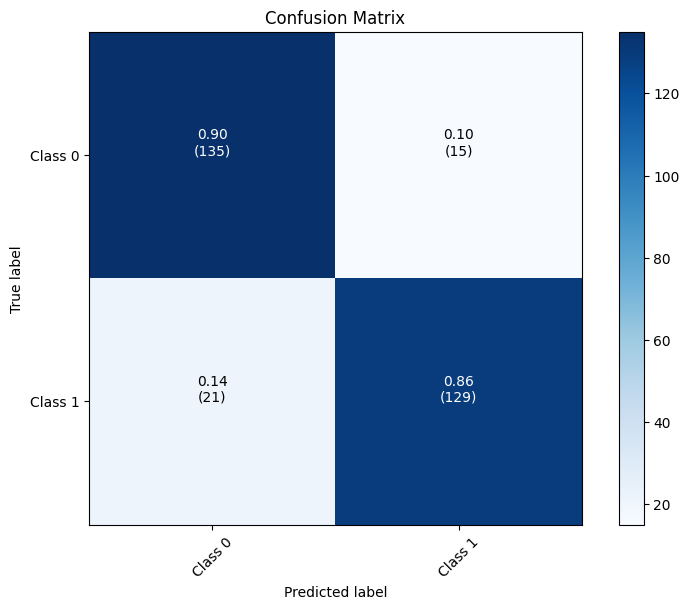

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Initialize variables for computing confusion matrix
y_true = []
y_pred = []

test_loss = 0.0
correct = 0
total = 0
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device).float().unsqueeze(1)
    with torch.no_grad():  # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)  # Accumulate total test loss
    
    # Apply threshold to get binary predictions
    pred = torch.round(output)
    
    # Append true and predicted labels for confusion matrix calculation
    y_true.extend(target.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct += correct_tensor.sum().item()
    total += target.size(0)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot colored confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Define tick marks for class labels
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Use white text if cells are dark; otherwise, black
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, "{:.2f}\n({:d})".format(conf_matrix_normalized[i, j], conf_matrix[i, j]),
             horizontalalignment='center',
             color='white' if conf_matrix[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print test loss and accuracy
test_loss = test_loss / len(test_loader.dataset)
#print('Test Loss: {:.4f}'.format(test_loss))
#print("Test Accuracy: {:.2f}%".format(100 * correct / total))


**Receiver Operating Characteristic curve**

Receiver Operating Characteristic curve, is a graphical plot that illustrates the performance of a binary classification model across different thresholds.

100%|██████████| 19/19 [00:01<00:00, 16.50it/s]


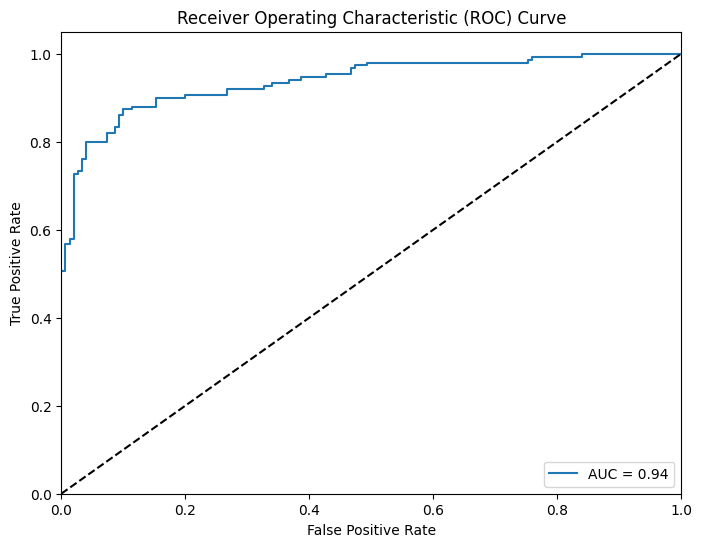

In [26]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Initialize variables for computing confusion matrix
y_true = []
y_pred = []
y_scores = []  # to store predicted probabilities

test_loss = 0.0
correct = 0
total = 0
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device).float().unsqueeze(1)
    with torch.no_grad():  # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)  # Accumulate total test loss
    
    # Get predicted probabilities and binary predictions
    probs = torch.sigmoid(output).squeeze()
    pred = torch.round(probs)

    # Append true labels and predicted probabilities for ROC curve calculation
    y_true.extend(target.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())
    y_scores.extend(probs.cpu().numpy())  # store predicted probabilities
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct += correct_tensor.sum().item()
    total += target.size(0)


# Compute ROC curve and AUC for the binary classification
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print test loss and accuracy
#test_loss = test_loss / len(test_loader.dataset)
#print('Test Loss: {:.4f}'.format(test_loss))
#print("Test Accuracy: {:.2f}%".format(100 * correct / total))
